## Loading Libraries

In [6]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
from memory_profiler import memory_usage
import dask.dataframe as dd

In [7]:
%load_ext rpy2.ipython
%load_ext memory_profiler

## Downloading the Data

In [5]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

In [6]:
# Downloading the file
files_to_dl = ["data.zip"]  
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [8]:
# Extracting the zip file
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

## Combining the CSV Files

In [25]:
%%time
%%memit
files = glob.glob('data/*NSW.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(Model = file.strip('data/').split('_')[0])
                for file in files))
df.to_csv("data/combined_data.csv")

peak memory: 81.87 MiB, increment: 0.00 MiB
CPU times: user 5min 59s, sys: 23.1 s, total: 6min 22s
Wall time: 6min 30s


##### Combining CSV Files from Jason's Machine
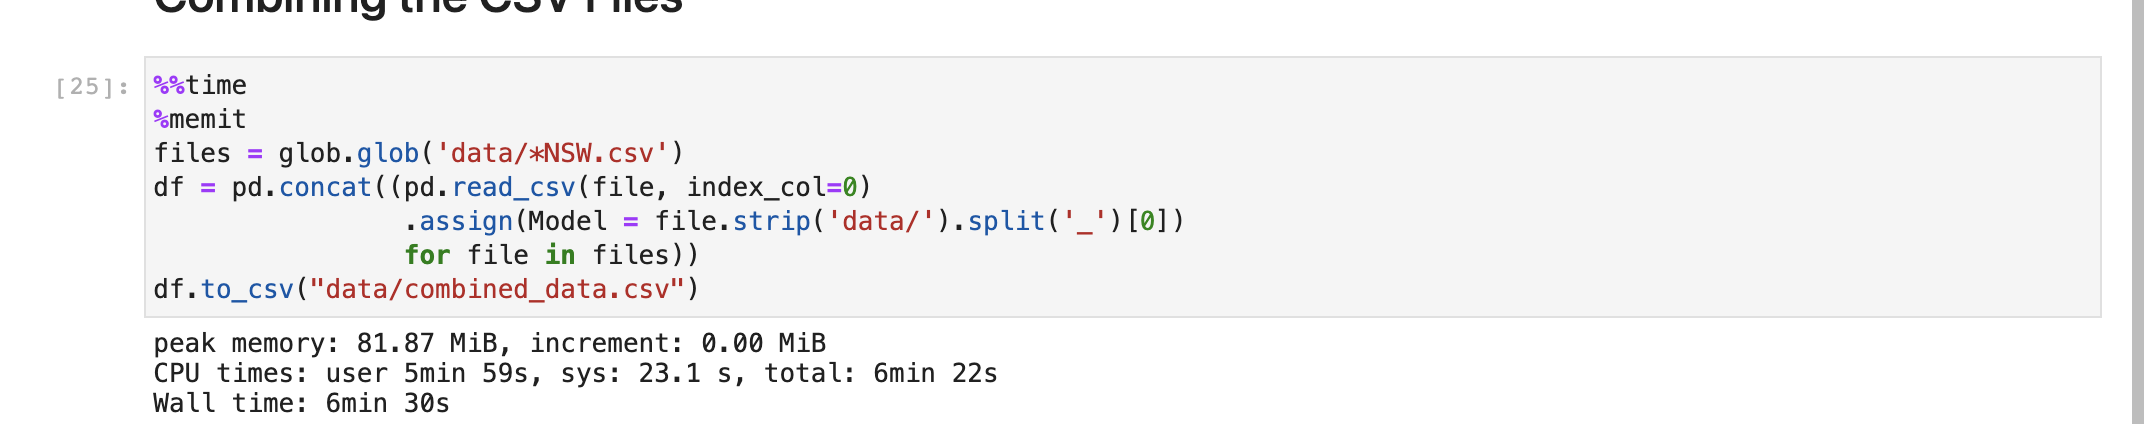

##### Combining CSV Files from Fei's Machine

##### Combining CSV Files from Julie's Machine

### Discussion of Memory and Time Spent on Combining CSVs

The peak memory used for Jason when combining the csv files is 81.87. In addition, the overall wall time for combining the csv file for Jason is 6 minutes 30 seconds.

In [26]:
%%sh
du -sh data/combined_data.csv

5.6G	data/combined_data.csv


### Exploring The Memory Usage by Loading the Data and Performing Simple EDA Via Several Methods

##### Memory Usage when Loading in the Combined CSV File with default Pandas method and counting Model

In [48]:
%%time
%%memit
combined_df = pd.read_csv('data/combined_data.csv')
print(combined_df['Model'].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
GFDL-CM4            3219300
FGOALS-f3-L         3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-LR        966420
AWI-ESM-1-1-LR       966420
NESM3                966420
NorESM2-LM           919800
CanESM5              551880
BCC-ESM1             551880
Name: Model, dtype: int64
peak memory: 3907.93 MiB, increment: 1315.26 MiB
CPU times: user 1min 3s, sys: 23.3 s, total: 1min 26s
Wall time: 1min 37s


In [30]:
combined_df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),Model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


##### Loading just the Model Column and Counting how many occurrences of each Model

In [49]:
%%time
%%memit
single_col = pd.read_csv('data/combined_data.csv', usecols = ['Model'])
print(single_col['Model'].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
GFDL-CM4            3219300
FGOALS-f3-L         3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-LR        966420
AWI-ESM-1-1-LR       966420
NESM3                966420
NorESM2-LM           919800
CanESM5              551880
BCC-ESM1             551880
Name: Model, dtype: int64
peak memory: 2558.91 MiB, increment: 90.87 MiB
CPU times: user 31 s, sys: 3.58 s, total: 34.6 s
Wall time: 36.2 s


##### Loading the data in Chunks and count how many occurrences of each Model

In [51]:
%%time
%%memit
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["Model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int64
peak memory: 2248.88 MiB, increment: 497.14 MiB
CPU times: user 58.5 s, sys: 7.67 s, total: 1min 6s
Wall time: 1min 7s


##### Loading the data in Dask and count how many occurrences of each Model

In [8]:
%%time
%%memit
dask_df = dd.read_csv('data/combined_data.csv')
print(dask_df["Model"].value_counts().compute())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: Model, dtype: int64
peak memory: 1795.29 MiB, increment: 1642.25 MiB
CPU times: user 1min 21s, sys: 20.8 s, total: 1min 42s
Wall time: 42 s


From the above result, we can see that loading the entire csv file at once using Pandas and performing the EDA consumes the most memory. On the other hand, the memory consumption when loading the data by chunks and loading a single column are relatively close. Finally, the memory usage when using dask is the lowest out of all methods.